<a href="https://colab.research.google.com/github/dmamur/elementsem/blob/main/elembert_classification_matbench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}/multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}/ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}/ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}/ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    position_embeddings = layers.Embedding(input_dim=config.MAX_LEN,output_dim=config.EMBED_DIM,
                                           weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
                                           name="position_embedding",)(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!git clone https://github.com/dmamur/elementsem.git

Cloning into 'elementsem'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 506 (delta 38), reused 1 (delta 1), pack-reused 445
Receiving objects: 100% (506/506), 90.00 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (255/255), done.
Updating files: 100% (256/256), done.


In [19]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 128
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=123456789
tf.random.set_seed(seed)
np.random.seed(seed)

In [20]:
ds = 'matbench'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [21]:
df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  101


In [22]:
len(types)

106113

# Convert types to integers

In [24]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/embert'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z = load_model(config.PREPATH+'/elEmBERT'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

#plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

epochs=config.BATCH_SIZE
model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2, mode='min',save_freq=1000,)

callbacks_list = [checkpoint,csv_logger]

print('dataLen: ',x3.shape,labels.shape)



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 element_embdgs (Embedding)     (None, 128, 32)      3232        ['types[0][0]']                  
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 128, 32)     0           ['element_embdgs[0][0]']         
 mbda)                                                                                            
                                                                                                  
 encoder_0/multiheadattention (  (None, 128, 32)     4224        ['tf.__operators__.add_5[0]

In [25]:
p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:round(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Epoch 1/128
664/664 [==============================] - 21s 21ms/step - loss: 0.4494 - auc_4: 0.8723 - val_loss: 0.3763 - val_auc_4: 0.9125
Epoch 2/128
335/664 [==============>...............] - ETA: 5s - loss: 0.3785 - auc_4: 0.9109
Epoch 2: saving model to /content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L_2_bert.h5.h5
664/664 [==============================] - 12s 18ms/step - loss: 0.3731 - auc_4: 0.9136 - val_loss: 0.3722 - val_auc_4: 0.9185
Epoch 3/128
664/664 [==============================] - 10s 16ms/step - loss: 0.3566 - auc_4: 0.9215 - val_loss: 0.3543 - val_auc_4: 0.9235
Epoch 4/128
  5/664 [..............................] - ETA: 8s - loss: 0.3327 - auc_4: 0.9318 
Epoch 4: saving model to /content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L_2_bert.h5.h5
664/664 [==============================] - 11s 16ms/step - loss: 0.3475 - auc_4: 0.9256 - val_loss: 0.3501 - val_auc_4: 0.9248
Epoch 5/128
343/664 [==============>...............] - ETA: 4s - loss: 0.3430 - auc

# Save results

In [26]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = validx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

830/830 [==============================] - 5s 6ms/step


# Evaluation on the test set

In [27]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

In [29]:
df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))

types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3test = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#model =load_model(mname+'.h5')

preds = model.predict(x3test,batch_size = config.BATCH_SIZE)

166/166 [==============================] - 2s 10ms/step


In [30]:
dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3test,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = np.arange(len(labels))
dbresults['testidx'] = np.arange(len(labels))
dbresults['validx'] = np.arange(len(labels))

with open(mname+'_test_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)


166/166 [==============================] - 2s 8ms/step


# Postprocessing

In [31]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [32]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: 0.90095186
/content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L_2_bert.h5  AUC: 0.9645927


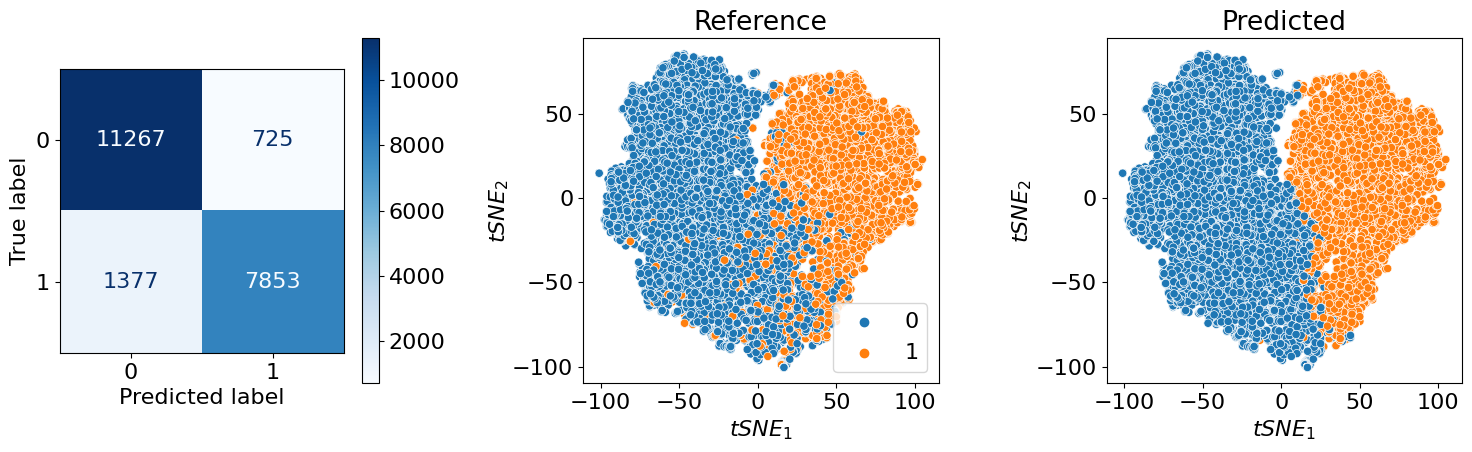

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")

binary tf-acc: 0.91395724
/content/elementsem/models/elembertB_matbench_V1_E_32_H_2_L_2_bert.h5  AUC: 0.9713871


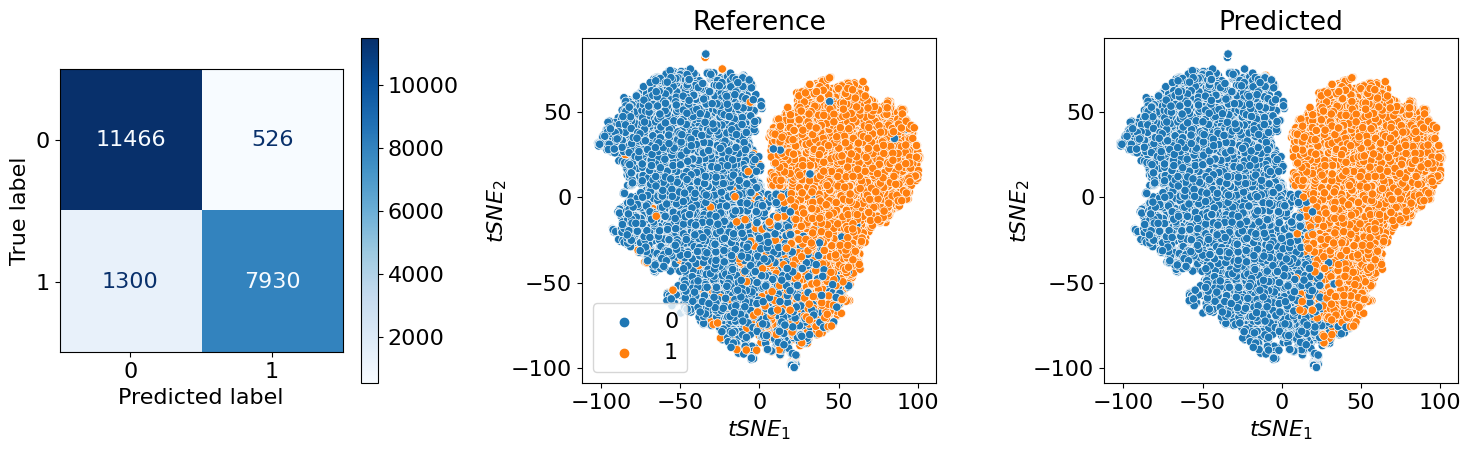

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")

binary tf-acc: 0.91070586
MTrainable_32_2_2 AUC: 0.9700589


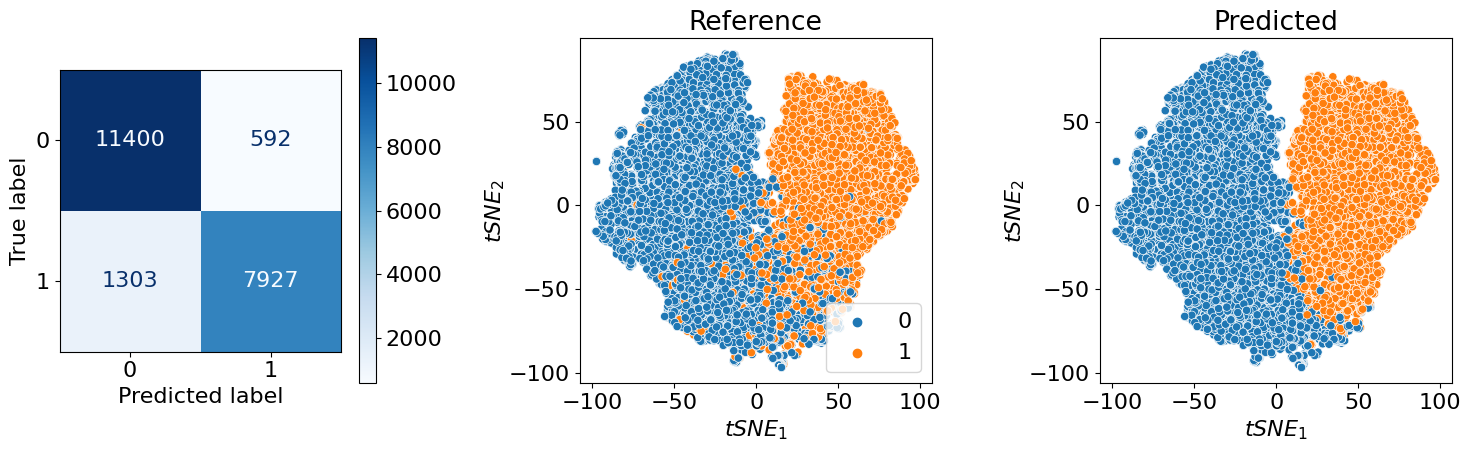

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print('MTrainable_32_2_2 AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")

binary tf-acc: 0.9544341
AUC: 0.98610216


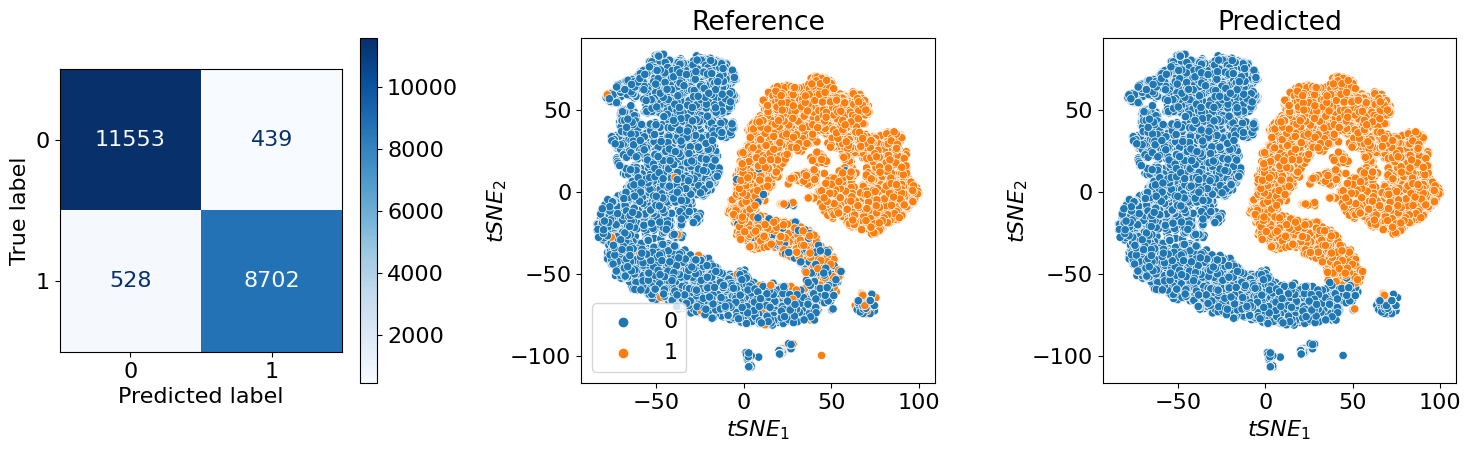

<Figure size 640x480 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print('AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")

binary tf-acc: 0.88097256
AUC: 0.94853574


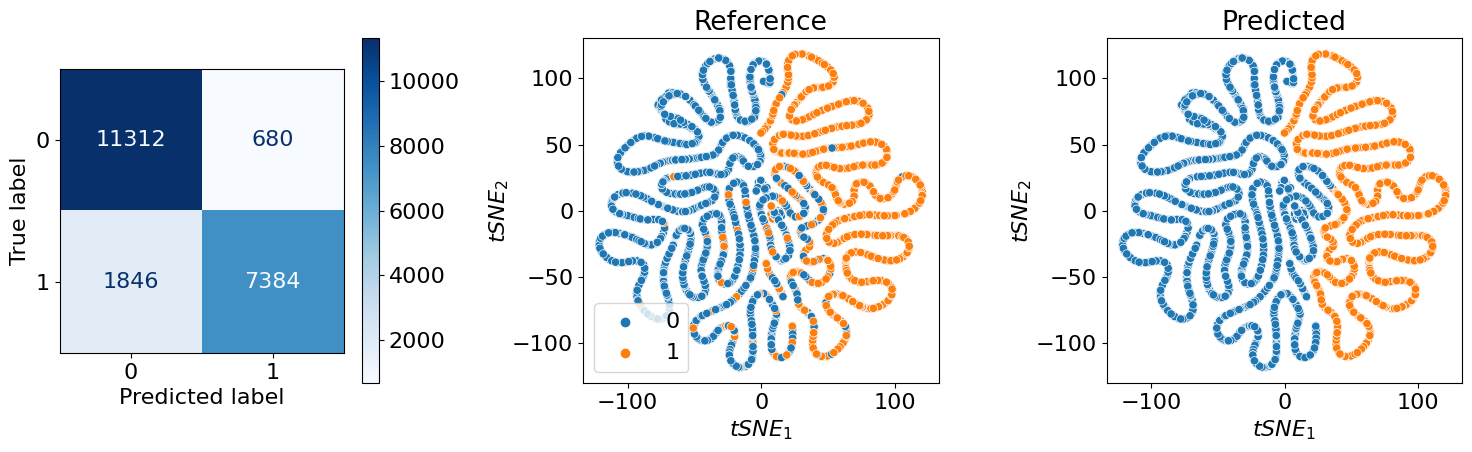

<Figure size 640x480 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print('AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")

binary tf-acc: 0.95221937
AUC: 0.9852545


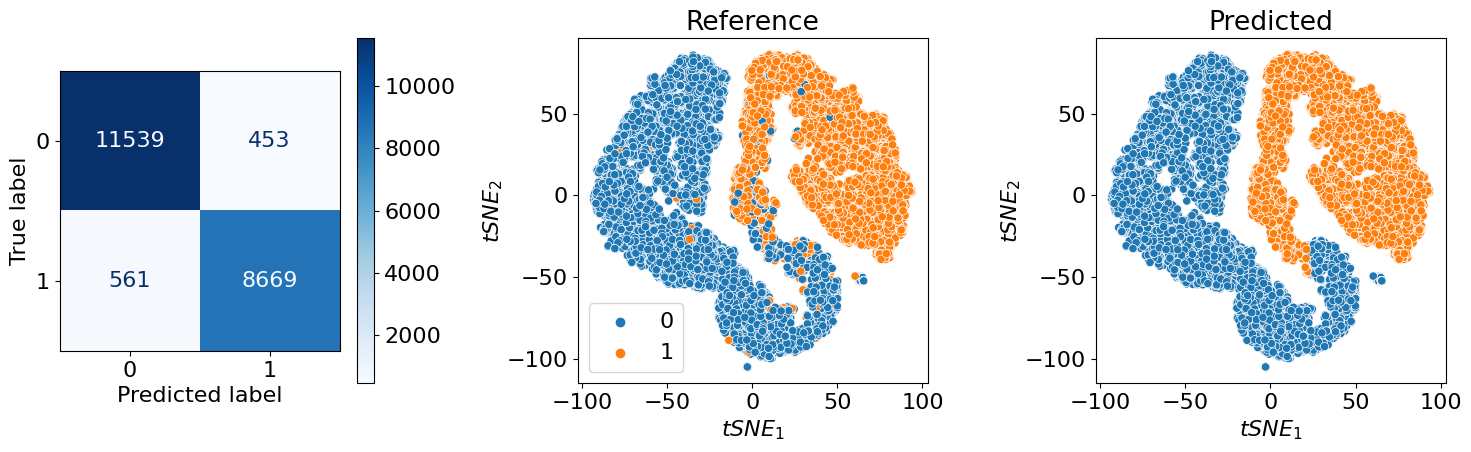

In [37]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print('AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
#plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")